### Movie Data Analysis
In this project, we will analyze movie data, specifically the film media (e.g. film vs. digital), the genre, and the budget.

In doing so, we will be trying to answer the following questions:
* How has the distribution of film media changed over time? 
* How has the distribution of genres changed over time?
* Does movie genre dictate film media?
* What are the distributions of budgets of each film media?

We start off with imports and getting an overview of the data. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('movies_film_digital.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1195 non-null   int64  
 1   production_year            1195 non-null   int64  
 2   title                      1195 non-null   object 
 3   directors                  1195 non-null   object 
 4   primary_genre              1195 non-null   object 
 5   genres                     1195 non-null   object 
 6   camera_format              1025 non-null   object 
 7   negative_format            1104 non-null   object 
 8   budget                     1195 non-null   int64  
 9   inflation_adjusted_budget  1195 non-null   float64
 10  budget_source              1195 non-null   object 
 11  film_type                  1141 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 112.2+ KB


In [4]:
df.head(3)

,id,production_year,title,directors,primary_genre,genres,camera_format,negative_format,budget,inflation_adjusted_budget,budget_source,film_type
0,4103791,2006,Pirates of the Caribbean: Dead Man's Chest,"Verbinski, Gore",Action/Adventure,Action|Adventure|Fantasy,"Arriflex 235, Panavision Primo Lenses|Panavisi...",35 mm,225000000,299587500.0,the-numbers,F
1,4022547,2006,Night at the Museum,"Levy, Shawn",Action/Adventure,Adventure|Comedy|Family|Fantasy,"Arriflex 435, Zeiss Ultra Prime and Angenieux ...",35 mm,110000000,146465000.0,the-numbers,F
2,3415583,2006,Cars,"Lasseter, John|Ranft, Joe",Animation,Animation|Comedy|Family|Sport,NaN,Digital,70000000,93205000.0,the-numbers,D


We only want to focus on a few of the top genres so that our visualizations are easy to interpret. To do this, we set all genres outside of the top 3 to 'Other'.

In [5]:
df.primary_genre = df.primary_genre.apply(lambda x: \
                    x if x in df.primary_genre.value_counts().head(3).index else 'Other')
df.primary_genre.value_counts()

Action/Adventure    550
Comedy              263
Other               241
Drama               141
Name: primary_genre, dtype: int64

In [6]:
# rename film types to be more readable
pd.options.mode.chained_assignment = None  # default='warn'
df.film_type.loc[df.film_type == 'F'] = 'Film'
df.film_type.loc[df.film_type == 'D'] = 'Digital'
df.film_type.loc[df.film_type == 'FD'] = 'Film and Digital'
df.film_type.value_counts()

Digital             521
Film                509
Film and Digital    111
Name: film_type, dtype: int64

The budget data may be more easily comparable if we scale down the data so that we have the values in terms of millions of dollars.

In [8]:
df.inflation_adjusted_budget.head(3)

0    299587500.0
1    146465000.0
2     93205000.0
Name: inflation_adjusted_budget, dtype: float64

In [9]:
# scale down budget values by 10^6
df.inflation_adjusted_budget /= 10**6
df.inflation_adjusted_budget = df.inflation_adjusted_budget[df.inflation_adjusted_budget != 0]

In [10]:
df.inflation_adjusted_budget.head(3)

0    299.5875
1    146.4650
2     93.2050
Name: inflation_adjusted_budget, dtype: float64

That's much better!

In [15]:
# Function to create stacked bar plots to create varying visualizations
def mult_stacked_bar(table: pd.crosstab, colors: list, bar_width: float=0.8,
                     legend_title: str='', counts: list=[], 
                     x_label: str='', figsize: list=[10,8], savefile: bool=False, filename: str='plot.png'):
    '''
    Creates a stacked bar plot with multiple bars
    
        Parameters:
            table (pd.crosstab): Crosstab of data
            colors (list):       List of colors to use for each bar
            legend_title (str):  Title for the legend
            counts (list):       List of counts to use for each bar
            x_label (str):       Label for the x-axis
            figsize (list):      Size of the figure
            savefile (bool):     Whether or not to save the plot
            filename (str):      Filename to save the plot as
    '''
    
    # set up and augment bar graph
    ax = table.plot(kind='bar', width=bar_width, stacked=True, 
                    fontsize=16, rot=0, figsize=figsize, 
                    color=colors)

    # augment spines, ticks, and axes
    [ax.spines[i].set_visible(False) for i in ax.spines]
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='x', length=0)
    plt.xlabel('')
    if x_label:
        plt.xlabel(x_label, fontsize=20, labelpad=10)

    n_rows = table.shape[0]
    n_cols = table.shape[1]

    # put relative proportions in the patches
    for i in range(n_rows):
        prev = 0
        for j in range(n_cols):
            current = table.iloc[i, j]
            ypos = current / 2 + prev
            ax.text(i, ypos, f'{current * 100:.0f}%',
                    ha='center', va='center',
                    color='white', fontsize='14', weight='bold')
            prev += current

    # put counts above patches
    if counts:
        for i in range(n_rows):
                ax.text(i, 1.025, f'n={str(counts[i])}',
                        fontsize=14,
                        ha='center')

    # set up and augment legend
    plt.legend(bbox_to_anchor=[1., 0.5], loc='center left',
            title=legend_title, title_fontsize=24, fontsize=16,
            frameon=False, markerfirst=False)

    # save the figure
    if savefile:
        plt.savefig(filename, bbox_inches='tight', dpi=200)
        # plt.savefig(filename, bbox_inches='tight', dpi=1000)

    return ax

### How has the distribution of film media changed over time? 
Start off by creating a crosstable of the data comparing the production year and film media.

In [13]:
table1 = pd.crosstab(df.production_year, df.film_type, normalize='index')
table1_nn = pd.crosstab(df.production_year, df.film_type)

# create counts for each bar
counts1 = [table1_nn.iloc[n].sum() for n in range(len(table1_nn))]

**Plot 1:** Stacked bar chart of the distribution of film media over time from 2006-2017.

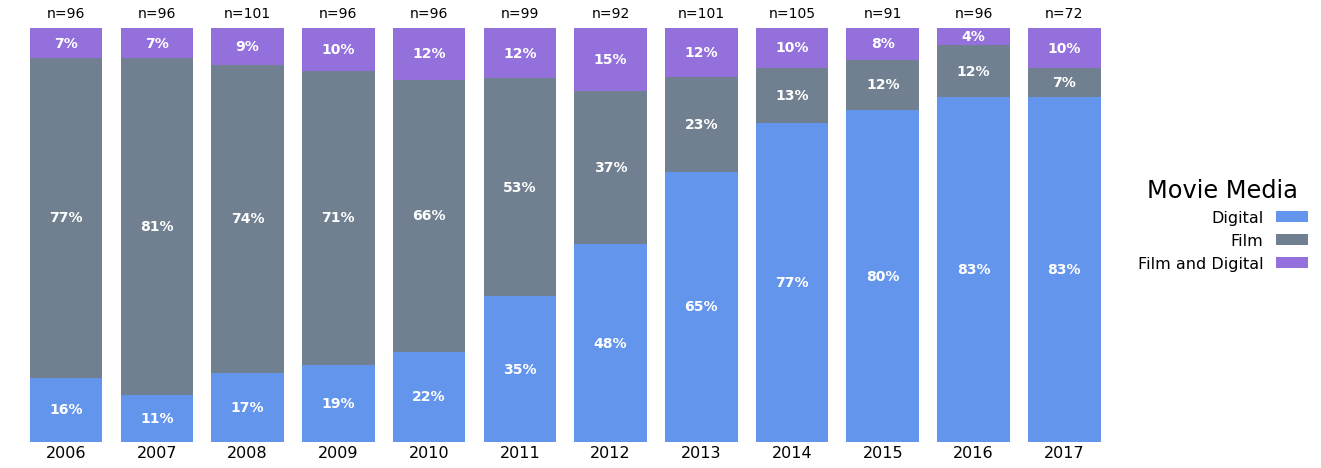

In [16]:
# visualize the distribution of movie media by year using the function
mult_stacked_bar(table=table1, colors=['cornflowerblue', 'slategrey', 'mediumpurple'],
                 counts=counts1, legend_title='Movie Media', figsize=[20,8],
                 savefile=False, filename='Film_by_Year.png')
plt.show()

We can see that back in 2006, the predominant movie medium was film and that film remained the primary medium up until 2012. After that, digital media took over by storm, and is used for the vast majority of movies in recent years. 

### How has the distribution of genres changed over time?
We will again create a crosstable of the data, but this time comparing the production year and genre of movies. 

In [17]:
table2 = pd.crosstab(df.production_year, df.primary_genre, normalize='index')
table2_nn = pd.crosstab(df.production_year, df.primary_genre)

# create counts for each bar
counts2 = [table2_nn.iloc[n].sum() for n in range(len(table2_nn))]

**Plot 2:** Stacked bar chart of the distribution of movie genre over time from 2006-2017.

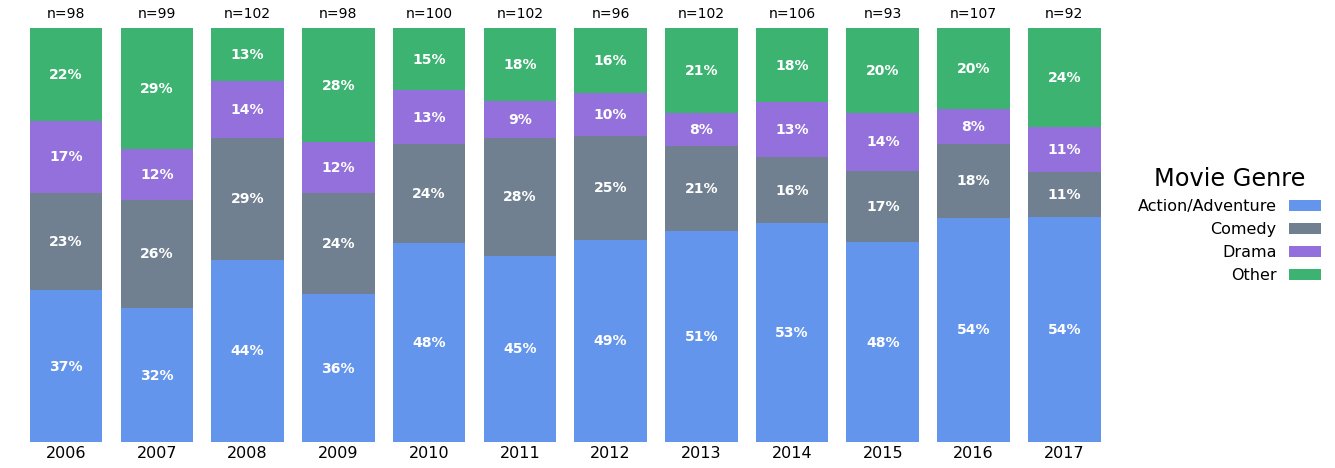

In [18]:
# visualize the distribution of movie genres by year using the function
mult_stacked_bar(table=table2, colors=['cornflowerblue', 'slategrey', 'mediumpurple', 'mediumseagreen'], 
                 counts=counts2, legend_title='Movie Genre', figsize=[20,8],
                 savefile=False, filename='Genre_by_Year.png')
plt.show()

We can see that there while action/adventure movies have always been the most common, they have picked up even more popularity in recent years. There is also an observable decline in the number of comedy movies with time, while dramas and other genres have remained generally stable. 

### Does movie genre dictate film media?

We will once more begin with creating a cross table of the data, but this time comparing movie genre to movie media. 

In [20]:
table3 = pd.crosstab(df.primary_genre, df.film_type, normalize='index')
table3_nn = pd.crosstab(df.primary_genre, df.film_type)

# create counts for each bar
counts3 = [table3_nn.iloc[n].sum() for n in range(len(table3_nn))]

**Plot 3:** Stacked bar chart of the distribution of movie genre over time from 2006-2017.

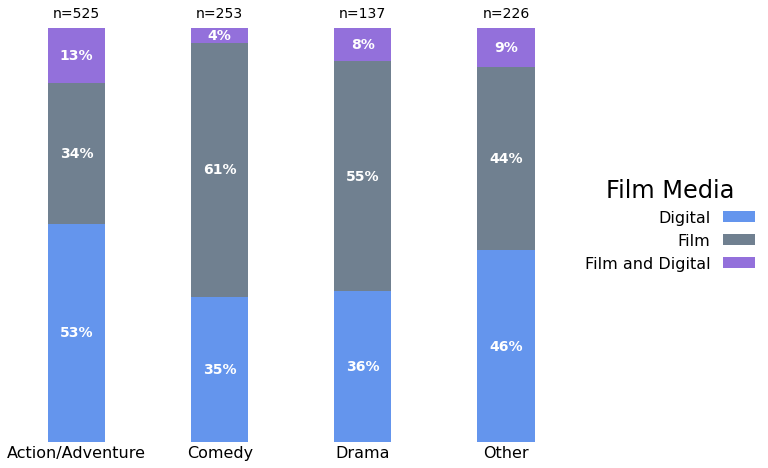

In [22]:
# visualize the distribution of movie media by genre using the function
mult_stacked_bar(table=table3, colors=['cornflowerblue', 'slategrey', 'mediumpurple'], 
                 bar_width = 0.4, counts=counts3, legend_title='Film Media', 
                 figsize=[10, 8], savefile=False, filename='Film_by_Genre.png')
plt.show()

We can see that it is action/adventure movies that use the digital medium most often, while comedies and ramas tend to make use of film more often. Understanding this data along with our previous visualizations, we can see that the decline in the usage of the film medium in recent years could also be due to the decline in comedy movies, which are primarily created using film. Meanwhile, the recent popularity of action/adventure movies⁠—which are primarily created using digital media⁠—could explain the recent rise in the usage of the digital medium. 

In [26]:
# Function to create boxplots to analyze distributions of movie budgets
def make_subplot_viz(values: list, labels: list, fontsize: int=16, title_fontsize: int=20, figsize: tuple=(20,8),
                     xlabel: str='', savefile: bool=False, filename: str='budget.png', 
                     colors: list=['cornflowerblue','slategrey','mediumpurple']):
    '''
    Creates boxplots of the distribution of values
    
        Parameters:
            values (list):        List of pd.Series or nd.array objects to plot
            labels (list):        List of labels to use for each bar
            fontsize (int):       Font size for the labels
            title_fontsize (int): Font size for the title
            figsize (tuple):      Figure size
            xlabel (str):         Label for the x-axis
            colors (list):        List of colors to use for each bar
            savefile (bool):      Whether or not to save the figure
            filename (str):       Name of the file to save
    '''

    # create figure and axes and set style
    f, axes = plt.subplots(nrows=3, ncols=1, figsize=figsize, sharex=True)
    sns.set_style('whitegrid')

    for i in range(len(axes)):
        
        # establish numerical variables
        count_media, mean_media, min_media, p25_media, p50_media, p75_media, max_media =\
            np.array(values[i].describe().drop(index='std')).reshape(7,)
        
        xtickvals = [count_media, mean_media, min_media, p25_media, p50_media, p75_media, max_media]
        xtickvals = [round(val) for val in xtickvals]
        if (mean_media - p50_media) / p50_media < 0.1:
            del xtickvals[1]
        
        # create and configure boxplot, plot axes, and spines
        sns.boxplot(ax=axes[i], data=values[i], width=0.33, orient='h', color=colors[i], showmeans=True,
                    medianprops={'linewidth': 2.5,
                                #  'color': 'k',
                                'alpha': 1},
                    meanprops={'marker': 'o',
                            'markerfacecolor': 'white', 
                            'markeredgecolor': 'black',
                            'markersize': 10},
                    flierprops={'marker': 'o', 
                                'markerfacecolor': colors[i],
                                #  'markeredgecolor': 'black',
                                'markersize': 10, 
                                'alpha': 0.5})
        
        axes[i].tick_params(axis='x', size=0, labelsize=fontsize)
        axes[i].set(yticklabels=[])
        axes[i].text(-8, 0, labels[i], ha='center', va='center', 
                    fontsize=fontsize, rotation='vertical')
        axes[i].text(-20, 0, f'n={xtickvals[0]}', ha='center', va='center', 
                    fontsize=fontsize, rotation='vertical')
        
        [axes[i].spines[j].set_visible(False) for j in axes[i].spines]
        
        # display numerical values
        for val in xtickvals[1:2]:   # mean
            axes[i].text(val, -0.27, str(val), ha='center', va='center', fontsize=fontsize)
        for val in xtickvals[3:-1]:   # median, p25, p50, p75
            axes[i].text(val, -0.27, str(val), ha='center', va='center', fontsize=fontsize)
        for val in xtickvals[-1:]:   # max
            axes[i].text(val, -0.16, str(val), ha='center', va='center', fontsize=fontsize)
        if xtickvals[2] not in [n for n in range(4)]:   # min
            for val in xtickvals[2:3]:
                axes[i].text(val, -0.16, str(val), ha='center', va='center', fontsize=16)
    
    plt.title(xlabel, fontsize=title_fontsize, va='center', ha='center', y=-0.4)
    
    if savefile:
        plt.savefig(filename, bbox_inches='tight', dpi=200)
        # plt.savefig(filename, bbox_inches='tight', dpi=1000)

    return f

### What are the distributions of budgets of each film media?
We can start off by separating the data into individual dataframes for each film media so that we can analyze each individually.

In [24]:
f = df[['film_type', 'inflation_adjusted_budget']]
f = f[f.film_type == 'Film']
film = pd.DataFrame(f.inflation_adjusted_budget)
film.columns = ['Film']

d = df[['film_type', 'inflation_adjusted_budget']]
d = d[d.film_type == 'Digital']
digital = pd.DataFrame(d.inflation_adjusted_budget)
digital.columns = ['Digital']

fd = df[['film_type', 'inflation_adjusted_budget']]
fd = fd[fd.film_type == 'Film and Digital']
f_and_d = pd.DataFrame(fd.inflation_adjusted_budget)
f_and_d.columns = ['Film and Digital']

**Plot 4:** Boxplots of the distribution of budgets for each film media.

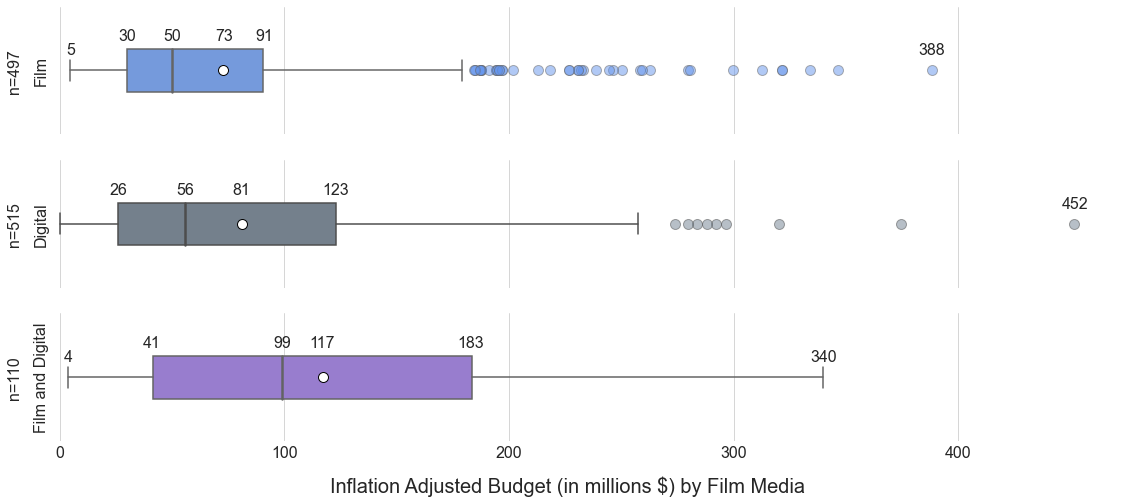

In [28]:
# visualize the distribution of movie budgets by movie media
make_subplot_viz(values=[film, digital, f_and_d], labels=['Film', 'Digital', 'Film and Digital'],
                 xlabel='Inflation Adjusted Budget (in millions $) by Film Media',
                 savefile=False, filename='Budget_by_Media.png')

plt.show()

We can see that the combination of film and digital tends to make a movie more expensive, while movies in film tend to run the cheapest. We can also see that there are some outliers for this data, such as the most expensive movie being a digital movie with a budget of about $452 million. Also, there are quite a few outliers for film movies, so even though film movies tend to be the least expensive, this is not always the case. 